# Importing and calling data files


In [65]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os
#import reionizer
import glob
import astropy
import astropy.cosmology
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate


# For plotting purposes
plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [9]:
def insensitive_glob(pattern):
    """
    Case insensitive find file names
    """
    def either(c):
        return '[%s%s]'%(c.lower(),c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either,pattern)))

#Call UV LF data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval

#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

# Methodology
## Defining function to call files


In [10]:
#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df



#Call UV LF files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 


#Call xHI, EW files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 


#Call EW file with xHI = 0.01 
pW_tab = load_uvf_pandas(pW_files[0]) 

#Get Muv values from EW file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])

## Defining constants and evaluating equations for given z value. Interpolating data between UV LF and Lya EW, Lya LF and L Grid

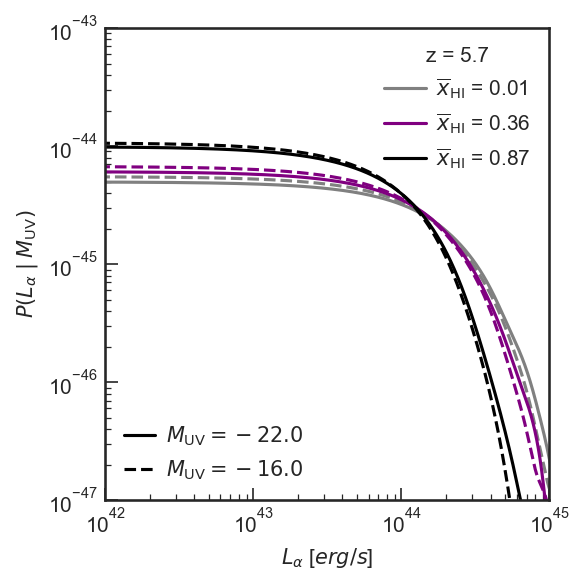

In [94]:
#Constants and constraints
xHI_array = np.array([0.01,0.36,0.87]) #chosen xHI value
zval_test = np.array([5.7]) #chosen redshifts
Muv_array = np.array([-22.0,-16.0]) #chosen Muv to test lum_lya vs Muv similar to EW vs Muv
beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-20 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light
lum_grid = np.logspace(42.5,45) #shape = (50,)
log10_lg = np.log10(lum_grid) #log10 luminosity grid in order to plot it on log10 scale similar to past works

plt.figure(figsize=(4.,4.), dpi=150)


#Defining for loop for all necessary eqs needed
for zz,zval2 in enumerate (LFz_tab): 
    if zval2 in zval_test:
        
        LF_tab = load_uvf_pandas(LFz_files[zz]) #Load in files
        
        #Get Muv values from file as an array to use
        Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
        
        #Interpolating UV LF Muv and ndens values into a 1d array
        LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
        new_ndens = LF_interp(Muv_EW)


        d_l = P15.luminosity_distance(zval2) #Defines distance modulus

        #Define apparent magnitude equation
        def muv(Muv_EW,d_l,zval2): 
            p1 = Muv_EW
            p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
            p3 = 2.5*(beta+1.0)*np.log10(zval2+1.0)
            ans = p1 + p2 + p3
            
            return ans
        muv = muv(Muv_EW,d_l,zval2)
        
        
        #Flux density of UV continuum at Lya wavelength from Muv for given zvals
        fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
        fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units
        
        #Jacobian - partial EW / partial Lya Luminosity for given zvals 
        jacobian = 1/((4*np.pi*d_l**2.)*fd_units)
        
        for xx,xHI in enumerate (xHI_tab): #For each index and corresponding xHI value in list of xHI, call specific data file
            if xHI in xHI_array:
                pW_tab = load_uvf_pandas(pW_files[xx])
                
                # Flux_Lya
                f_lya = np.outer(pW_tab['W'],fd_units) * u.Angstrom
                #* u.erg/u.s*(u.cm**(-2)) 
                #I believe Angstrom was giving error previously because it was being ran in python2? 
                
                #Drops first column of EW values
                new_pW_tab = np.exp(pW_tab.drop('W',axis=1))
                #new_pW_tab = pW_tab.drop('W',axis=1) this was original code, was changed to exponential form
                
                #EW values for each Muv in EW file
                pEW_vals = np.array(new_pW_tab) 
                
                
                # P(Lya|Muv)
                pLya = jacobian * pEW_vals #Jacobian (1D) * EW_vals (2D) = pLya (2D) 
                
                
                #Lya luminosity 
                lum_lya = (f_lya * (4*np.pi*d_l**2.)).to(u.erg/u.s)
                
                
                #Normalizes pLya to correctly plot lum_lya vs pLya
                A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
                integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
                sum_int = A1 + integral #This is whole integral of p(L)dL
                norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize

                new_A1 = norm_pLya[0]
                integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
                new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
                assert(new_sum.value.all() == 1.)
                
                #Define an empty matrix in order to fill later with luminosity grid values and Muv values
                new_pLya = np.zeros((len(lum_grid), len(Muv_EW))) 
                
                
                for mm,Muv in enumerate (Muv_EW):
                        #Interpolating pLya and ndens values into a 1d array
                        LF_interp = interpolate.interp1d(lum_lya[:,mm],norm_pLya[:,mm],fill_value='extrapolate') #old values, MUST BE 1D
                        new_pLya[:,mm] = LF_interp(lum_grid) #column values of pLya
                        
                #Product of UVLF ndens values * pLya in new luminosity grid
                product_LF = new_ndens * new_pLya 

                #Integral of this product = Lya LF (missing fudge factor corrections)
                lya_LF = np.trapz(product_LF) 

                #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
                log10_LF = lya_LF*np.log(10)*lum_grid
                
                
                if xHI == 0.01:
                    my_color = 'gray' 
                    label = '$\overline{x}_\mathrm{HI}$ = %.2f'%xHI
#                     label = 'z = %.1f'%zval2 + ' @ xHI = %.2f'%xHI
                elif xHI == 0.36:
                    my_color = 'purple'
                    label = '$\overline{x}_\mathrm{HI}$ = %.2f'%xHI
                else: 
                    my_color = 'black'
                    label = '$\overline{x}_\mathrm{HI}$ = %.2f'%xHI
                    
        #Within if statement, this is for identifying xHI legend (values and corresponding colors)
                for mm,Muv in enumerate (Muv_array):
                    if mm == 0: #first item in Muv_array, i.e. -16.0
                        ls = 'solid'
                    elif mm == 1: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                        ls = 'dashed'
                        label = None
                  
                    
                    
                    
                    #These are all different plots that use the same info in order to plot, that can be commented out 

                    plt.loglog(lum_lya[:,mm], norm_pLya[:,mm], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
#                     plt.plot(lum_grid, new_pLya[:,mm], ls=ls, color = 'blue')
#                     plt.semilogy(log10_lg, log10_LF, color = 'black', label=label)
                    #plt.semilogy(lum_lya[:,mm],pW_tab['W'], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
leg_zval = plt.legend(title = 'z = %.1f'%zval_test,frameon=False, handletextpad=0.5, loc = 'upper right')
plt.gca().add_artist(leg_zval)

# #Lum grid VS LF Plot 
# plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
# plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ Mpc^-3$')


# L vs pLya Plot
# This is the legend for Muv values, -16.0 is solid, -22.0 is dashed
line2 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
line3 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
plt.legend(handles=[line2, line3], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

plt.ylim(1e-47,1e-43)
plt.xlim(1e42,1e45)
plt.xlabel(r'${{L_\alpha}}$ [$erg/s$]')
plt.ylabel('')
plt.ylabel(r'${ P (L_\alpha \;|\; M_\mathrm{UV})}$')
#ylabel [$\mathrm{\AA} cm^2 s/erg Mpc^2$]
plt.tight_layout()
# #Save the figure
plt.savefig('LvsPLya.pdf', dpi=300, bbox_inches='tight')

plt.show()


# Plot UV LF values vs interpolated Muv that is the same as EW 
#         plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval2) #UV LF values (181 Muv vals)
#         plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
#         #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
#         plt.legend()
#         plt.xlabel('$M_\mathrm{UV}$')
#         plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
#         plt.show()



#Plot jacobian vs Muv
        # Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
        # As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
#         plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)
        
# plt.legend()
# plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
# plt.ylabel('$M_\mathrm{UV}$')
# plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
        
# #Save the figure(s), rename figure title
# plt.savefig('LyaLFplot.pdf', dpi=300, bbox_inches='tight')

# plt.show()
        

        

# Test Code

In [487]:
#TEST integration
lower = np.amin(Muv_EW)
upper = np.amax(Muv_EW)
limits = np.array([lower,upper])
integral = np.trapz(product, x = limits, dx = Muv_EW)
print(integral.shape)

(10000,)


In [810]:
A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
sum_int = A1 + integral #This is whole integral of p(L)dL
norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize

new_A1 = norm_pLya[0]
integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
assert (new_sum.value.all() == 1.)



lower = np.amin(Muv_EW)
upper = np.amax(Muv_EW)
limits = np.array([lower,upper])
lyalf = np.trapz(LF_product, x = limits)
print(lyalf)

1
